In [1]:

import matplotlib.pyplot as plt
import numpy as np
from math import pi
     

from qutip import *
from scipy import *

In [41]:
toy_models = {
            "1":
               {
                   "j_map" : [[0,1,1,-1,0],[1,0,1,0,-1],[1,1,0,1,1],[-1,0,1,0,1],[0,-1,1,1,0]],
                   "gs_indeces": [  {"i":0, "suppressed": True},
                                    {"i":3, "suppressed": False},
                                    {"i":7, "suppressed": False}]
                   },
            "2": {
                    "j_map" : [[0,2,1,2,1],[2,0,-2,-1,1],[1,-2,0,1,2],[2,-1,1,0,-2],[1,1,2,-2,0]],
                    "gs_indeces": [{"i":0, "suppressed": False},
                                    {"i":2, "suppressed": False},
                                    {"i":5, "suppressed": True},
                                    {"i":6, "suppressed": False},
                                    {"i":8, "suppressed": False},
                                    {"i":9, "suppressed": False}]
                },
            "3": {
                    "j_map" : [[0,0,1,0,0,0],[0,0,0,1,0,0],[1,0,0,-1,1,-1],[0,1,-1,0,1,-1],[0,0,1,1,0,1], [0,0,-1,-1,1,0]],
                    "gs_indeces": [{"i":1, "suppressed": True},
                                    {"i":20, "suppressed": False},
                                    {"i":23, "suppressed": False}]
                },

            "4": {
                    "j_map" : [[0,1,0,0],[0,0,-1,-1],[0,-1,0,-1],[0,-1,-1,0]],
                    "gs_indeces": [{"i":1, "suppressed": True},
                                    {"i":2, "suppressed": True},
                                    {"i":3, "suppressed": False}]
                },

            
            
            }

model = toy_models["1"]
j_map = model["j_map"]
gs_indeces = model["gs_indeces"]
N = len(j_map[0])

In [42]:


si = qeye(2)
sz = sigmaz()


# Problem Hamiltonian
# Hp = -sum(Jij sigma_i_z sigma_j_z)


Hp = 0
for i in range(len(j_map)):
    for j in range(i,len(j_map[i])):

        sigma_i = [si if k != i else sz for k in range(N) ]
        sigma_j = [si if l != j else sz for l in range(N) ]

        Hp += j_map[i][j] * tensor(sigma_i) * tensor(sigma_j)   


print(Hp)
print(Hp.diag())

Quantum object: dims = [[2, 2, 2, 2, 2], [2, 2, 2, 2, 2]], shape = (32, 32), type = oper, isherm = True
Qobj data =
[[4. 0. 0. ... 0. 0. 0.]
 [0. 2. 0. ... 0. 0. 0.]
 [0. 0. 2. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 2. 0. 0.]
 [0. 0. 0. ... 0. 2. 0.]
 [0. 0. 0. ... 0. 0. 4.]]
[ 4.  2.  2.  4. -4. -2. -2.  4.  2. -4.  0. -2. -2. -4.  0.  2.  2.  0.
 -4. -2. -2.  0. -4.  2.  4. -2. -2. -4.  4.  2.  2.  4.]


In [43]:
# transverse field hamiltonian

si = qeye(2)
sx = sigmax()

Ht = 0
for i in range(N):
    sigma_x = [si if k != i else sx for k in range(N)]
    Ht += tensor(sigma_x)


Ht2 = 0

for i in range(N):
    for j in range(i+1,N):
        sigma_x_ij = [si if k not in (i,j) else sx for k  in range(N)]
        Ht2 += tensor(sigma_x_ij)

Ht2

Quantum object: dims = [[2, 2, 2, 2, 2], [2, 2, 2, 2, 2]], shape = (32, 32), type = oper, isherm = True
Qobj data =
[[0. 1. 1. ... 0. 0. 0.]
 [1. 0. 2. ... 0. 0. 0.]
 [1. 2. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 2. 1.]
 [0. 0. 0. ... 2. 0. 1.]
 [0. 0. 0. ... 1. 1. 0.]]

In [39]:
# Iterate through annealing times

gs_probs = [[] for i in range(len(gs_indeces))]
total_prob = []

for log_T in np.arange(-1,4,0.1):

    taulist = np.linspace(0, (10**log_T), 10000)

    # Initialize in equal superposition
    psi_list = [(1/np.sqrt(2))*(basis(2,0) + basis(2,1)) for n in range(N)]
    psi0 = tensor(psi_list)


    # the time-dependent hamiltonian in list-function format
    args = {"t_max": max(taulist)}
    h_t = [
        [-Ht-Ht2, lambda t, args: (args["t_max"] - t) / args["t_max"]],
        [-Hp, lambda t, args: t / args["t_max"]],
    ]

    # transform Hamiltonian to QobjEvo
    h_t = QobjEvo(h_t, args=args)

    res = sesolve(h_t, psi0, taulist, [], args)
    final_state = [(x.real**2 + x.imag**2)[0] for x in  res.states[-1].full()]
    t_p = 0
    for i, gs_info in enumerate(gs_indeces):
        gs_probs[i].append(2*final_state[gs_info["i"]])
        t_p += 2*final_state[gs_info["i"]]
    total_prob.append(t_p)


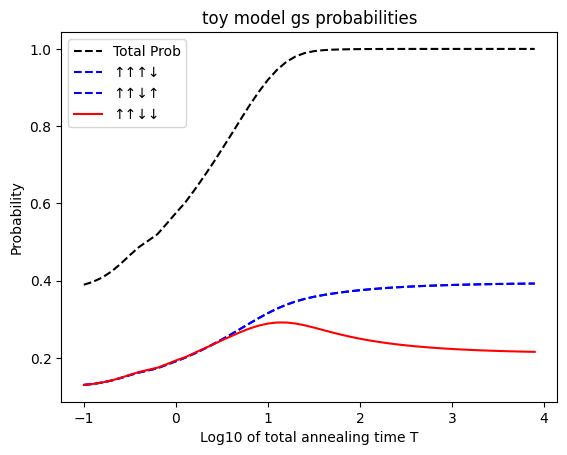

In [40]:
unicode_map = {"0": "\u2191", "1": "\u2193"}

plt.plot([i for i in np.arange(-1,4,0.1)], total_prob, color= "black", linestyle='--', label = "Total Prob")

for i,gs in enumerate(gs_indeces):
    plt.plot([i for i in np.arange(-1,4,0.1)], gs_probs[i], color = "blue" if gs["suppressed"] else "red", linestyle='--' if gs["suppressed"] else '-', label = "".join([unicode_map[c] for c in bin(gs["i"])[2:].zfill(N)]))


plt.title("toy model gs probabilities")
plt.xlabel("Log10 of total annealing time T")
plt.ylabel("Probability")
plt.legend()
plt.show()

In [162]:
#
# callback function for each time-step
#

M = 8
evals_mat = np.zeros((len(taulist), M))
P_mat = np.zeros((len(taulist), M))

idx = [0]

def process_rho(tau, psi):

    # evaluate the Hamiltonian with gradually switched on interaction
    H = h_t(tau)

    # find the M lowest eigenvalues of the system
    evals, ekets = H.eigenstates(eigvals=M)

    evals_mat[idx[0], :] = np.real(evals)

    # find the overlap between the eigenstates and psi
    for n, eket in enumerate(ekets):
        # print(eket.dag())
        # print((abs((eket.dag() * psi)) ** 2).data)
        P_mat[idx[0], n] = float(((abs((eket.dag() * psi)) ** 2).data or [0])[0])
        # P_mat[idx[0], n] = np.abs(np.dot(eket.full().flatten(),psi.full().flatten()))

    idx[0] += 1

In [163]:
# Check final state fidelity with true gs

annealing_time_log10 = 4


taulist = np.linspace(0, (10**annealing_time_log10), 10000)

# Initialize in equal superposition
psi_list = [(1/np.sqrt(2))*(basis(2,0) + basis(2,1)) for n in range(N)]
psi0 = tensor(psi_list)


# the time-dependent hamiltonian in list-function format
args = {"t_max": max(taulist)}
h_t = [
    [-Ht, lambda t, args: (args["t_max"] - t) / args["t_max"]],
    [-Hp, lambda t, args: t / args["t_max"]],
]

# transform Hamiltonian to QobjEvo
h_t = QobjEvo(h_t, args=args)

mesolve(h_t, psi0, taulist, [], process_rho, args)

# final_state = res.states[-1] 

# evals, ekets = h_t((10**annealing_time_log10)-0.1).eigenstates(eigvals=1)


/var/folders/84/h0vjvdyd5jsfdwfh08421q980000gn/T/ipykernel_95437/1736075728.py:25: ComplexWarning: Casting complex values to real discards the imaginary part
  P_mat[idx[0], n] = float(((abs((eket.dag() * psi)) ** 2).data or [0])[0])
/var/folders/84/h0vjvdyd5jsfdwfh08421q980000gn/T/ipykernel_95437/1736075728.py:25: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  P_mat[idx[0], n] = float(((abs((eket.dag() * psi)) ** 2).data or [0])[0])


Result object with sesolve data.
--------------------------------
expect = True
num_expect = 1, num_collapse = 0

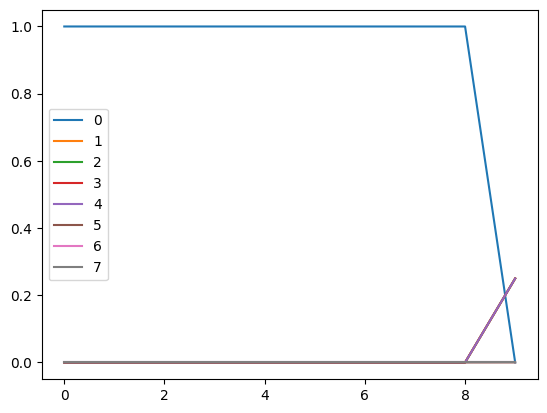

In [165]:
for ni,egsf in enumerate(P_mat.T):
    plt.plot(egsf[9990:], label = ni)

# plt.xscale('log')
plt.legend()
plt.show()


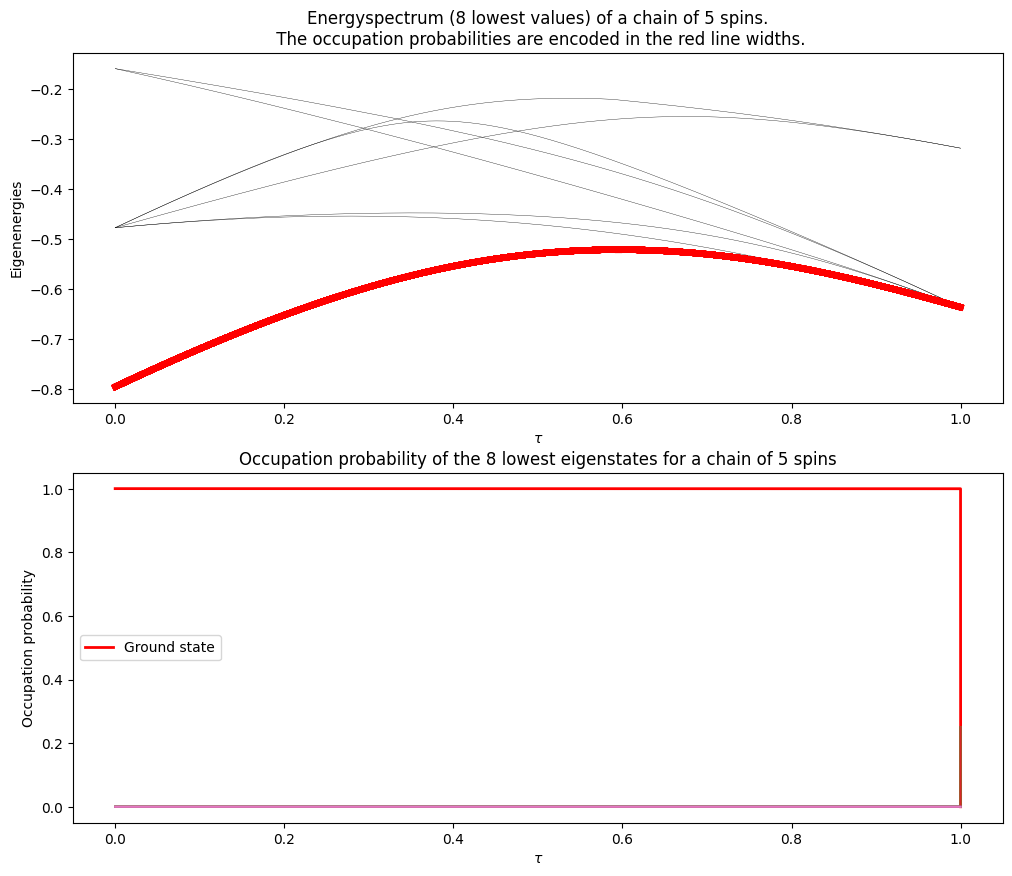

In [128]:
# rc('font', family='serif')
# rc('font', size='10')

fig, axes = plt.subplots(2, 1, figsize=(12, 10))

#
# plot the energy eigenvalues
#

# first draw thin lines outlining the energy spectrum
for n in range(len(evals_mat[0, :])):
    ls, lw = ("b", 1) if n == 0 else ("k", 0.25)
    axes[0].plot(taulist / max(taulist), evals_mat[:, n] / (2 * np.pi),
                 ls, lw=lw)

# second, draw line that encode the occupation probability of each state in
# its linewidth. thicker line => high occupation probability.
for idx in range(len(taulist) - 1):
    for n in range(len(P_mat[0, :])):
        lw = 0.5 + 4 * P_mat[idx, n]
        if lw > 0.55:
            axes[0].plot(
                np.array([taulist[idx], taulist[idx + 1]]) / (10**annealing_time_log10),
                np.array([evals_mat[idx, n],
                          evals_mat[idx + 1, n]]) / (2 * np.pi),
                "r",
                linewidth=lw,
            )

axes[0].set_xlabel(r"$\tau$")
axes[0].set_ylabel("Eigenenergies")
axes[0].set_title(
    "Energyspectrum (%d lowest values) of a chain of %d spins.\n " % (M, N)
    + "The occupation probabilities are encoded in the red line widths."
)

#
# plot the occupation probabilities for the few lowest eigenstates
#
for n in range(len(P_mat[0, :])):
    if n == 0:
        axes[1].plot(taulist / max(taulist), 0 + P_mat[:, n], "r", linewidth=2)
    else:
        axes[1].plot(taulist / max(taulist), 0 + P_mat[:, n])

axes[1].set_xlabel(r"$\tau$")
axes[1].set_ylabel("Occupation probability")
axes[1].set_title(
    "Occupation probability of the %d lowest " % M
    + "eigenstates for a chain of %d spins" % N
)
axes[1].legend(("Ground state",));

In [116]:
P_mat[idx[0],0]

0.9999999999999998